In [ ]:
#Importing Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import streamlit as st
from PIL import Image


In [ ]:
#Set Paths
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

os.makedirs('models', exist_ok=True)

In [ ]:
#Constants
img_size = (224,224)
batch_size = 32

# Building CNN Model from Scratch

In [ ]:
#Data Augmentation and Normalization

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(train_dir,
                                         target_size = img_size,
                                         batch_size = batch_size,
                                         class_mode = 'categorical'
                                         )

val_data = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_dir,
                                         target_size = img_size,
                                         batch_size = batch_size,
                                         class_mode = 'categorical'
                                         )

test_data = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir,
                                         target_size = img_size,
                                         batch_size = batch_size,
                                         class_mode = 'categorical',
                                         shuffle = False
                                         )

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [ ]:
# Compute Class Weights to Handle Imbalance
from sklearn.utils.class_weight import compute_class_weight

# Get class labels and number of samples per class
class_labels = list(train_data.class_indices.keys())
class_indices = train_data.class_indices
y_train = train_data.classes

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

print("📊 Computed Class Weights:")
for idx, weight in class_weights_dict.items():
    print(f"{class_labels[idx]}: {weight:.2f}")


📊 Computed Class Weights:
animal fish: 0.52
animal fish bass: 18.86
fish sea_food black_sea_sprat: 0.99
fish sea_food gilt_head_bream: 1.00
fish sea_food hourse_mackerel: 0.99
fish sea_food red_mullet: 0.98
fish sea_food red_sea_bream: 0.99
fish sea_food sea_bass: 1.05
fish sea_food shrimp: 0.98
fish sea_food striped_red_mullet: 1.03
fish sea_food trout: 0.98


In [6]:
# Building CNN Architecture

def CNN_Architecture(input_shape= (224,224,3), num_classes = None ):

    model = Sequential()
    model.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same' , input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256,(3,3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = CNN_Architecture(num_classes= train_data.num_classes)
model.summary()







Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                     

In [ ]:
#Model Training
callbacks = [EarlyStopping(patience = 5 , restore_best_weights = True),
             ModelCheckpoint('models/best_model_4.h5', save_best_only = True, monitor = 'val_accuracy')]

In [8]:

history = model.fit(train_data,
                   validation_data = val_data,
                   epochs = 15,
                   callbacks = callbacks,
                   class_weight=class_weights_dict,
                   verbose = 1
                   )


Epoch 1/15


195/195 [==============================] - ETA: 0s - loss: 1.9064 - accuracy: 0.3777

d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


195/195 [==============================] - 845s 4s/step - loss: 1.9064 - accuracy: 0.3777 - val_loss: 5.4162 - val_accuracy: 0.0962
Epoch 2/15
195/195 [==============================] - 703s 4s/step - loss: 1.3441 - accuracy: 0.5266 - val_loss: 4.3938 - val_accuracy: 0.2060
Epoch 3/15
195/195 [==============================] - 524s 3s/step - loss: 1.1330 - accuracy: 0.6199 - val_loss: 3.0143 - val_accuracy: 0.2088
Epoch 4/15
195/195 [==============================] - 482s 2s/step - loss: 0.9361 - accuracy: 0.6562 - val_loss: 1.0672 - val_accuracy: 0.6154
Epoch 5/15
195/195 [==============================] - 483s 2s/step - loss: 0.8006 - accuracy: 0.7184 - val_loss: 1.2482 - val_accuracy: 0.5540
Epoch 6/15
195/195 [==============================] - 498s 3s/step - loss: 0.7209 - accuracy: 0.7365 - val_loss: 2.1132 - val_accuracy: 0.3700
Epoch 7/15
195/195 [==============================] - 488s 3s/step - loss: 0.6255 - accuracy: 0.7682 - val_loss: 0.7483 - val_accuracy: 0.6786
Epoch 8/15

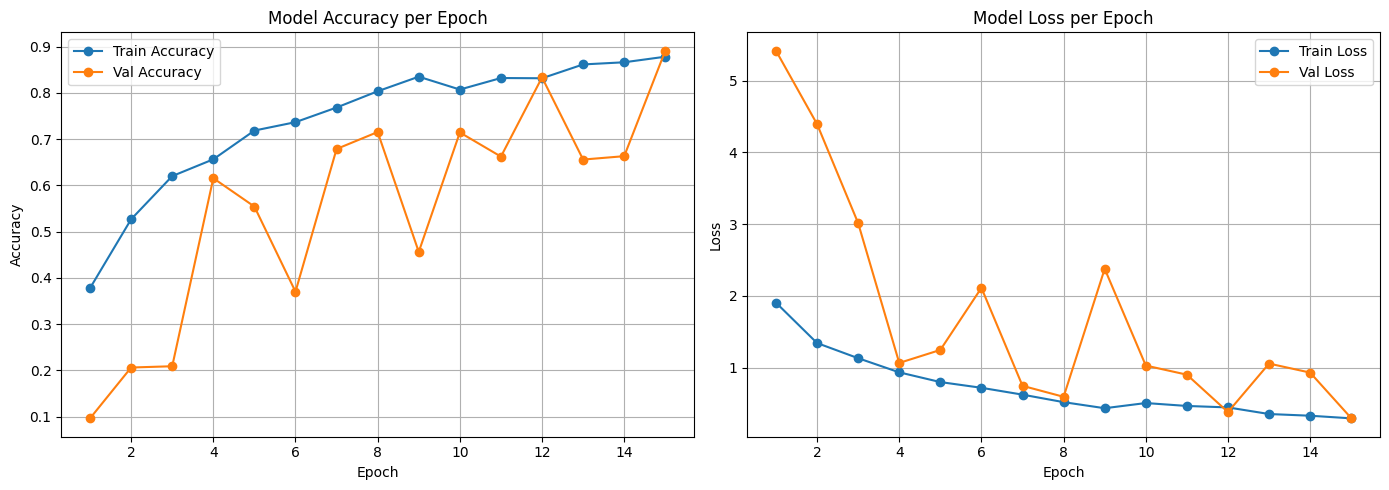

In [9]:
# ✅ Plot Training & Validation Accuracy and Loss

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='o')
    plt.title('Model Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Val Loss', marker='o')
    plt.title('Model Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_curves(history)


100/100 [==============================] - 81s 799ms/step

🔍 Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.84      0.90       520
                animal fish bass       0.11      0.77      0.20        13
   fish sea_food black_sea_sprat       0.88      0.92      0.90       298
   fish sea_food gilt_head_bream       0.87      0.70      0.78       305
   fish sea_food hourse_mackerel       0.74      0.99      0.85       286
        fish sea_food red_mullet       0.99      0.99      0.99       291
     fish sea_food red_sea_bream       0.99      0.66      0.79       273
          fish sea_food sea_bass       0.93      0.85      0.89       327
            fish sea_food shrimp       0.99      1.00      0.99       289
fish sea_food striped_red_mullet       0.84      0.99      0.91       293
             fish sea_food trout       0.97      0.99      0.98       292

                        ac

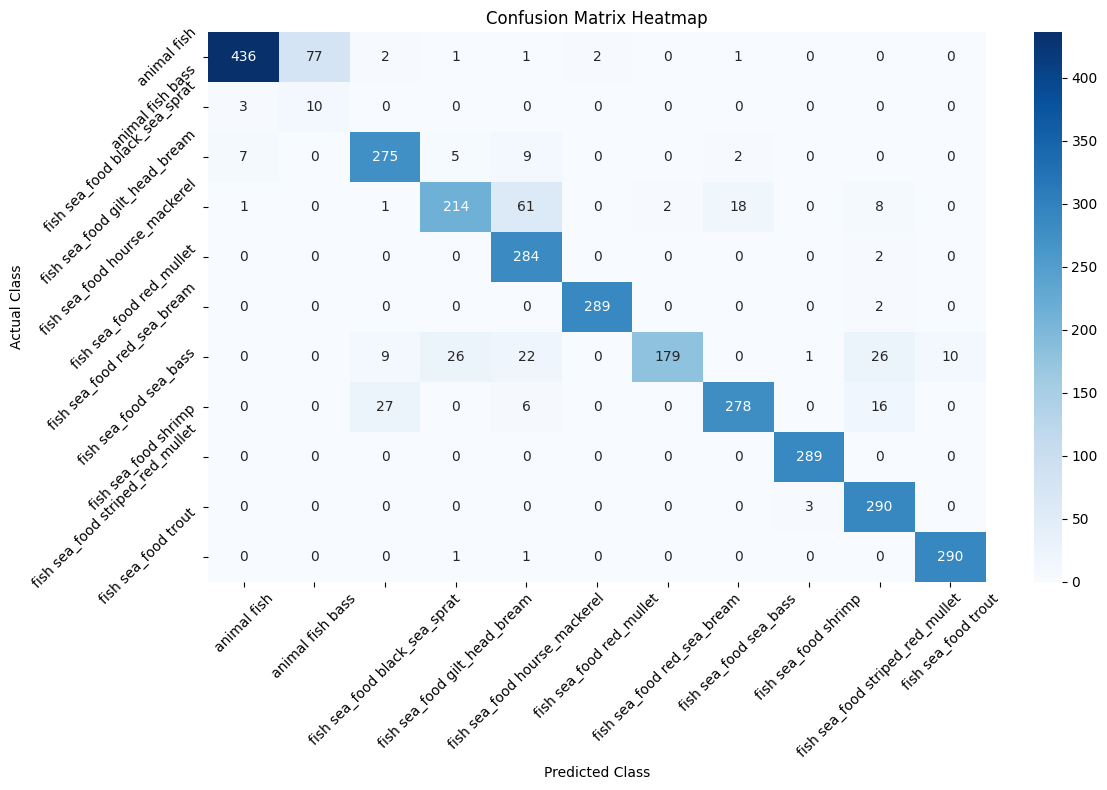

In [10]:
def evaluate_model(model, test_data):
    preds = model.predict(test_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_data.classes
    class_names = list(test_data.class_indices.keys())

    print("\n🔍 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    print("\n📊 Confusion Matrix Table (Actual vs Predicted):")
    print(df_cm)

    print("\n📌 How to Read This Table:")
    print("Each row = actual class, Each column = predicted class")
    print("Values in diagonal (↘️) = correct predictions")
    print("Off-diagonal values = misclassifications")

    plt.figure(figsize=(12, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.title('Confusion Matrix Heatmap')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_data)

# Training Pre-Trained Model using Transfer Learning

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

In [ ]:
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = train_data.num_classes

In [13]:
def build_transfer_model(base_model_class, input_shape=IMG_SHAPE, num_classes=NUM_CLASSES, trainable=False):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = trainable  # Freeze base initially

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
models_to_train = {
    "MobileNet": build_transfer_model(MobileNet),
    "EfficientNetB0": build_transfer_model(EfficientNetB0),
    "ResNet50": build_transfer_model(ResNet50),
    "InceptionV3": build_transfer_model(InceptionV3, input_shape=(299, 299, 3)),  # higher res
    "VGG16": build_transfer_model(VGG16)
}


In [15]:
histories = {}

for name, model in models_to_train.items():
    print(f"🧠 Training {name} model...")

    if "Inception" in name:
        train_gen = datagen.flow_from_directory(train_dir, target_size=(299, 299), batch_size=batch_size, class_mode='categorical')
        val_gen = datagen.flow_from_directory(val_dir, target_size=(299, 299), batch_size=batch_size, class_mode='categorical')
    else:
        train_gen = train_data
        val_gen = val_data

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks,
        class_weight=class_weights_dict
    )

    histories[name] = history  # ✅ Save history for plotting

    model.save(f"models/fish_{name.lower()}.h5")
    print(f"✅ Saved model: fish_{name.lower()}.h5")


🧠 Training MobileNet model...
Epoch 1/15
195/195 [==============================] - 216s 1s/step - loss: 1.8291 - accuracy: 0.4071 - val_loss: 0.7687 - val_accuracy: 0.8462
Epoch 2/15
195/195 [==============================] - ETA: 0s - loss: 0.8575 - accuracy: 0.7221

d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


195/195 [==============================] - 181s 925ms/step - loss: 0.8575 - accuracy: 0.7221 - val_loss: 0.3886 - val_accuracy: 0.9084
Epoch 3/15
195/195 [==============================] - 192s 983ms/step - loss: 0.5990 - accuracy: 0.8064 - val_loss: 0.2772 - val_accuracy: 0.9377
Epoch 4/15
195/195 [==============================] - 184s 943ms/step - loss: 0.4265 - accuracy: 0.8718 - val_loss: 0.1806 - val_accuracy: 0.9551
Epoch 5/15
195/195 [==============================] - 182s 934ms/step - loss: 0.3417 - accuracy: 0.8898 - val_loss: 0.1467 - val_accuracy: 0.9615
Epoch 6/15
195/195 [==============================] - 184s 941ms/step - loss: 0.2930 - accuracy: 0.9102 - val_loss: 0.1243 - val_accuracy: 0.9679
Epoch 7/15
195/195 [==============================] - 182s 935ms/step - loss: 0.2474 - accuracy: 0.9280 - val_loss: 0.0948 - val_accuracy: 0.9789
Epoch 8/15
195/195 [==============================] - 184s 945ms/step - loss: 0.2212 - accuracy: 0.9301 - val_loss: 0.0799 - val_accura

In [16]:
def plot_histories(histories_dict):
    for name, history in histories_dict.items():
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 5))

        # Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Train Accuracy')
        plt.plot(epochs_range, val_acc, label='Val Accuracy')
        plt.title(f'{name} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Train Loss')
        plt.plot(epochs_range, val_loss, label='Val Loss')
        plt.title(f'{name} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()


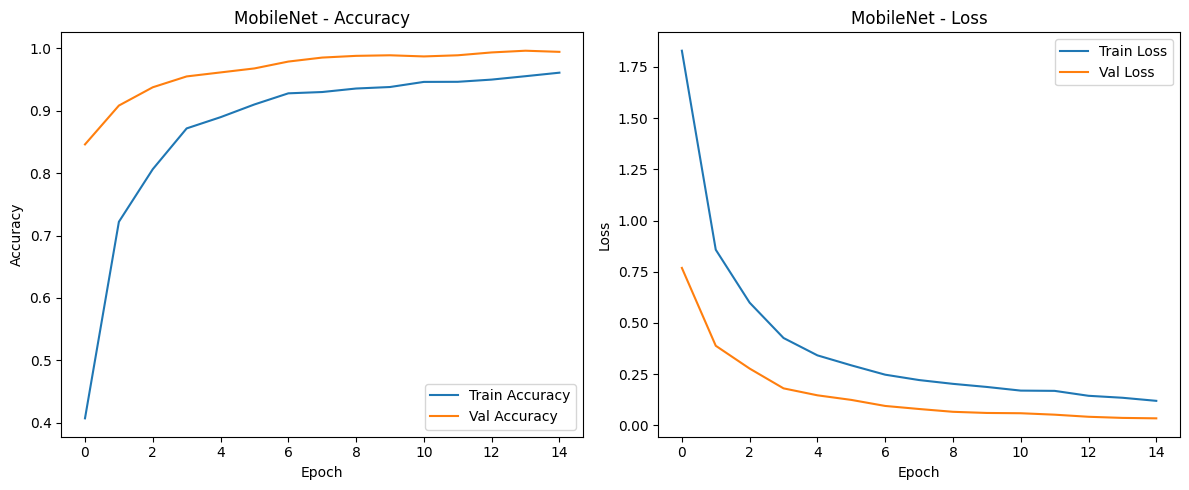

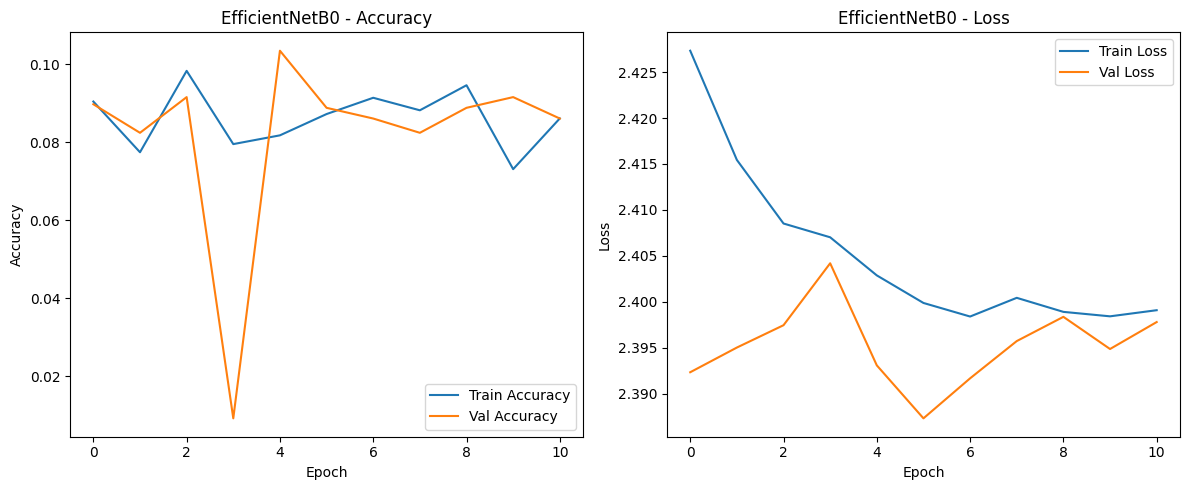

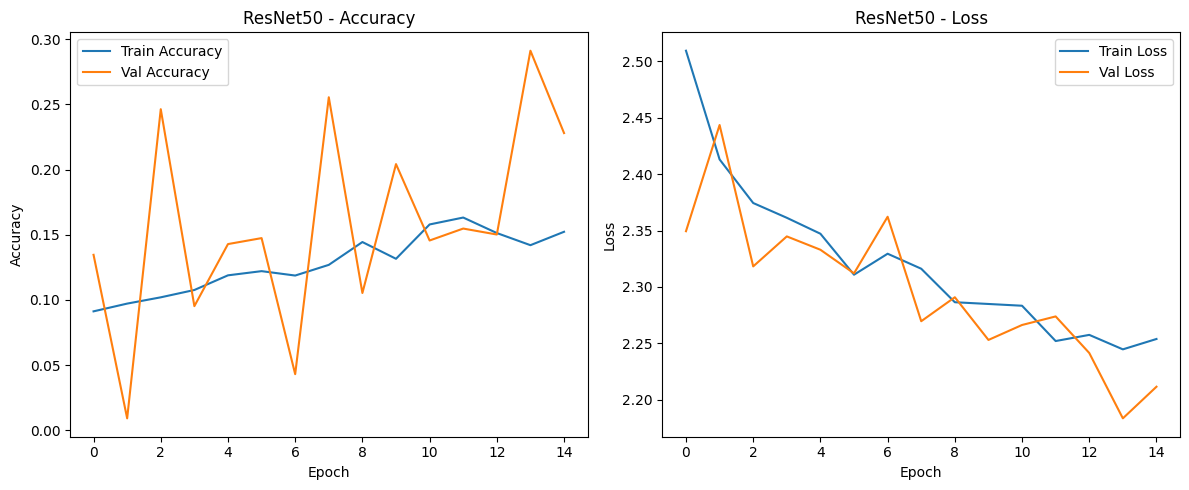

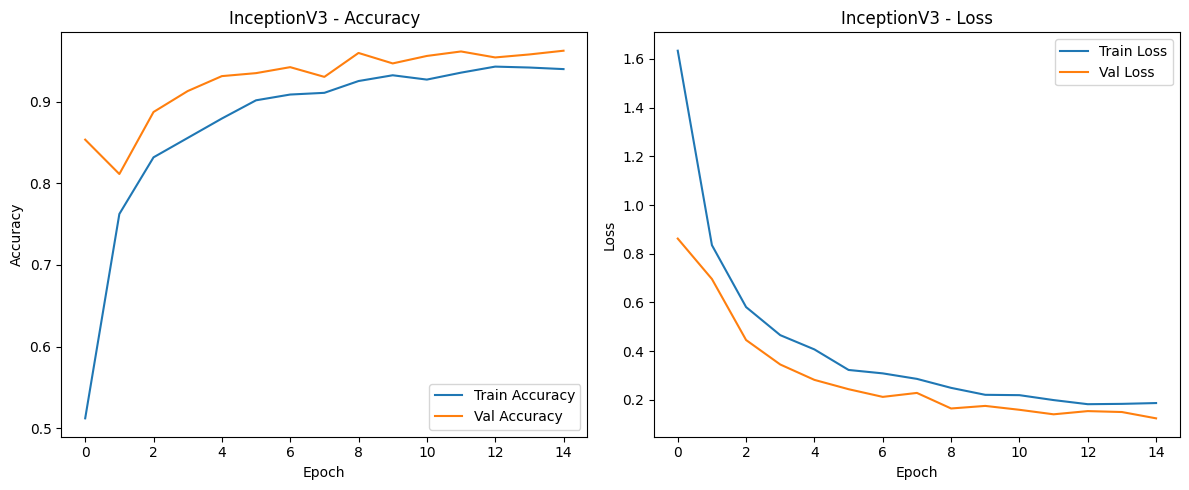

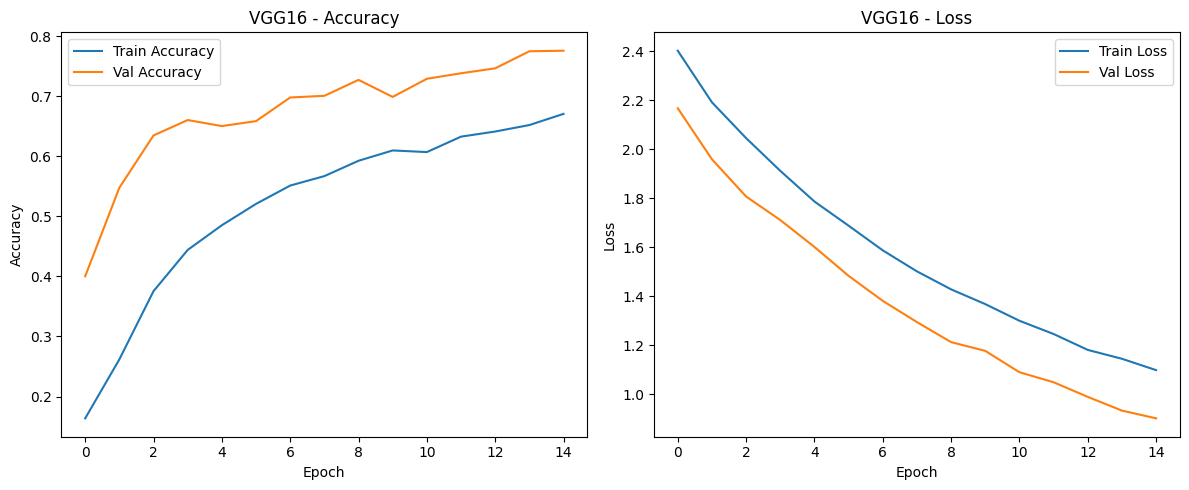

In [17]:
plot_histories(histories)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Create a directory to save reports
os.makedirs("evaluation_reports", exist_ok=True)

# List to store summary
summary_metrics = []

# ✅ Evaluation Function
def evaluate_and_store_metrics(model_path, test_data, model_name="Model"):
    model = load_model(model_path)
    preds = model.predict(test_data, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_data.classes
    class_names = list(test_data.class_indices.keys())

    # Save classification report
    report_txt = classification_report(y_true, y_pred, target_names=class_names)
    with open(f"evaluation_reports/{model_name}_classification_report.txt", "w") as f:
        f.write(report_txt)

    # Save confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"evaluation_reports/{model_name}_confusion_matrix.png")
    plt.close()

    # Append macro average scores
    summary_metrics.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro Precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "Macro Recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "Macro F1-Score": f1_score(y_true, y_pred, average='macro', zero_division=0)
    })

In [ ]:
# ✅ Evaluate All Models (one by one)
model_names = ["resnet50", "mobilenet", "inceptionv3", "efficientnetb0", "vgg16"]

for model_name in model_names:
    model_path = f"models/fish_{model_name}.h5"
    try:
        print(f"\n🔍 Evaluating {model_name.upper()}...\n")
        evaluate_and_store_metrics(model_path, test_data, model_name=model_name.upper())
    except Exception as e:
        print(f"❌ Failed to evaluate {model_name.upper()}: {str(e)}")


🔍 Evaluating RESNET50...



d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and bein


🔍 Evaluating MOBILENET...


🔍 Evaluating INCEPTIONV3...


🔍 Evaluating EFFICIENTNETB0...



d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

In [20]:
# Create summary dataframe
df_model_summary = pd.DataFrame(summary_metrics)
print("\n📈 Summary of All Model Evaluations:")
print(df_model_summary)


📈 Summary of All Model Evaluations:
            Model  Accuracy  Macro Precision  Macro Recall  Macro F1-Score
0        RESNET50  0.207091         0.269906      0.259548        0.169965
1       MOBILENET  0.991842         0.965119      0.993054        0.976367
2     INCEPTIONV3  0.935362         0.890194      0.934808        0.900612
3  EFFICIENTNETB0  0.102604         0.009328      0.090909        0.016919


In [21]:
# Step 1: Convert list to DataFrame (already done)
df_model_summary = pd.DataFrame(summary_metrics)

# Step 2: Find the Best Model based on Accuracy (or change to 'Macro F1-Score' if needed)
best_model_row = df_model_summary.loc[df_model_summary['Accuracy'].idxmax()]
best_model_name = best_model_row['Model'].lower()

print(f"🏆 Best model based on accuracy: {best_model_name.upper()} with Accuracy = {best_model_row['Accuracy']:.4f}")

# Step 3: Set path for best model
best_model_path = f"models/fish_{best_model_name}.h5"
final_model_path = "models/best_fish_classifier_model.h5"

best_model = load_model(best_model_path)
best_model.save(final_model_path)

print(f"✅ Saved the best model as: {final_model_path}")


🏆 Best model based on accuracy: MOBILENET with Accuracy = 0.9918


d:\DataScience\GUVI\DataScience_GUVI_Projects\Fish_Image_Classification\fish_img_classifier_venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Saved the best model as: models/best_fish_classifier_model.h5
